In [60]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import os
from functools import partial
import pandas as pd

In [61]:
# Generate the dataset

np.random.seed(20)
d = 2
b = 10
n = 2000
theta_true = np.zeros(2)
sigma = 1.5 * np.eye(d) 

# Prior
sigma0 = .5 * np.eye(d) + .5 * np.ones((d, d))
sigma0_inv = np.linalg.inv(sigma0)

# Likelihood
sigma1 = 1.5 * np.eye(d) - .5 * np.ones((d, d))
sigma1_inv = np.linalg.inv(sigma1)

# Y contains the Gaussian samples
Y = ss.multivariate_normal.rvs(mean=theta_true, cov=sigma1, size=n)
Y_split = np.array_split(Y, b)

In [62]:
## Define a fonction to display the contour of Gaussian densities
def gauss_draw(mu, sigma, low = -1, high = 1):
    # compute a space grid
    Zx, Zy = np.meshgrid(np.linspace(low, high, num=100), np.linspace(low, high, num=100))
    Z = np.stack((Zx, Zy)).T.reshape(-1, 2)
    # define the considered pdf
    def pdf(x): return ss.multivariate_normal.pdf(x, mean=mu, cov=sigma)
    # Y contains the values of the density calculated
    Y = np.fromiter(map(pdf, Z), dtype='float').reshape(Zx.shape).T
    # plot the contours
    plt.contour(Zx, Zy, Y, levels=1,colors='grey',linestyles='dashed',alpha=0.5)
    # plt.clabel(CS, inline=1, fontsize=4)
    # display the center
    #plt.plot(mu[0], mu[1], '*', color='cyan', markersize=6)
    
## Define a fonction to display the contour of Gaussian densities
def gauss_draw_true(mu, sigma, low = -1, high = 1):
    # compute a space grid
    Zx, Zy = np.meshgrid(np.linspace(low, high, num=100), np.linspace(low, high, num=100))
    Z = np.stack((Zx, Zy)).T.reshape(-1, 2)
    # define the considered pdf
    def pdf(x): return ss.multivariate_normal.pdf(x, mean=mu, cov=sigma)
    # Y contains the values of the density calculated
    Y = np.fromiter(map(pdf, Z), dtype='float').reshape(Zx.shape).T
    # plot the contours
    plt.contour(Zx, Zy, Y, levels=3,colors='red',linestyles='solid')
    # plt.clabel(CS, inline=1, fontsize=4)
    # display the center
    #plt.plot(mu[0], mu[1], '*', color='cyan', markersize=6)

In [63]:
class GaussianPosterior:

    def __init__(self, X, mu, sigma0, sigma1):
        self.X = X
        self.mu = mu
        self.sigma0_inv, self.sigma1_inv = np.linalg.inv(sigma0), np.linalg.inv(sigma1)

    def sigma_posterior(self):
        self.sigma_post = np.linalg.inv(self.sigma0_inv + len(self.X) * self.sigma1_inv)

    def mu_posterior(self):
        self.mu_post = self.sigma_post.dot(self.sigma1_inv.dot(self.X.sum(axis=0)) + self.sigma0_inv.dot(self.mu))

In [50]:
1/M

0.0024875621890547263

In [144]:
# Pseudo-marginal version of DG-LMC 
R = [50/M,20/M,10/M,5/M,1/M]
num_particles = [1,5,10]
T = 100000
N = 1
n_shard = int(n/b)
M = 1 / np.linalg.eigvalsh(sigma0)[0] + n_shard / np.linalg.eigvalsh(sigma1)[0]
theta = np.zeros((len(R),len(num_particles),T,d))
alpha = np.zeros((T,len(R),len(num_particles)))

for r in range(len(R)):
    print(float(r/len(R)))
    rho = R[r]
    gamma = rho/(2*(rho*M+1))

    for k in range(len(num_particles)):
        print(float(k/len(num_particles)))
        K = num_particles[k]

        # Params of the target posterior
        sigma_post = np.linalg.inv(np.linalg.inv(sigma0) + len(Y)*np.linalg.inv(sigma1))
        mu_post = sigma_post.dot(np.linalg.inv(sigma1).dot(Y.sum(axis=0)) + np.linalg.inv(sigma0).dot(theta_true))
        Q_post = np.linalg.inv(sigma_post)
        
        z = np.zeros((b,d))

        for t in range(T-1):

            # Sample z_i with N_i steps of ULA
            for i in range(b):
                Q = sigma0_inv/b + n_shard * sigma1_inv
                mu = np.linalg.inv(Q).dot((sigma0_inv/b).dot(theta_true) + np.sum(sigma1_inv.dot(Y_split[i].T),1))
                for j in range(N):
                    z[i,:] = z[i,:] * (1 - gamma/rho) + (gamma/rho) * theta[r,k,t,:] - gamma * Q.dot(z[i,:] - mu) \
                             + np.sqrt(2*gamma)*np.random.normal(0,1,size=2)

            # Sample proposed theta_tilde
            theta_tilde = np.mean(z,0) + np.sqrt(rho/b) * np.random.normal(0,1,size=2)

            # Compute the acceptance ratio

            ## Compute the contribution of the target distribution
            r1 = np.exp(-0.5*(theta_tilde-mu_post).dot(Q_post.dot(theta_tilde-mu_post)) \
                    +0.5*(theta[r,k,t,:]-mu_post).dot(Q_post.dot(theta[r,k,t,:]-mu_post)))

            ## Compute the ratio between the two proposal distributions

            ### Sample K samples from R_gamma given theta_t and theta_tilde
            zt = np.zeros((b,d,K))
            ztilde = np.zeros((b,d,K))
            for i in range(b):
                Q = sigma0_inv/b + n_shard * sigma1_inv
                mu = np.linalg.inv(Q).dot((sigma0_inv/b).dot(theta_true) + np.sum(sigma1_inv.dot(Y_split[i].T),1))
                zt[i,:] = np.reshape(z[i,:],(d,1)) * (1 - gamma/rho) + (gamma/rho) * np.reshape(theta[r,k,t,:],(d,1)) \
                          - gamma * np.reshape(Q.dot(z[i,:] - mu),(d,1)) \
                          + np.sqrt(2*gamma)*np.random.normal(0,1,size=(d,K))
                ztilde[i,:] = np.reshape(z[i,:],(d,1)) * (1 - gamma/rho) + (gamma/rho) * np.reshape(theta_tilde,(d,1)) \
                             - gamma * np.reshape(Q.dot(z[i,:] - mu),(d,1)) \
                             + np.sqrt(2*gamma)*np.random.normal(0,1,size=(d,K))

            ### Compute the pseudo-marginal approximation
            r2 = np.sum(np.exp(-np.sum(np.linalg.norm(np.reshape(theta[r,k,t,:],(d,1))-ztilde,2,1)**2/(2*rho),0))) \
                / np.sum(np.exp(-np.sum(np.linalg.norm(np.reshape(theta_tilde,(d,1))-zt,2,1)**2/(2*rho),0)))

            # Accept/Reject step
            alpha[t,r,k] = np.minimum(1,r1*r2)
            #if t % 1000:
            #    print(alpha[t,r,k])
            u = np.random.uniform()
            if u <= alpha[t,r,k]:
                theta[r,k,t+1,:] = theta_tilde
            else:
                theta[r,k,t+1,:] = theta[r,k,t,:]
                
        print(np.mean(alpha[0:T,r,k]))
                


        #theta = np.squeeze(theta)[int(T/10):]

0.0
0.0
0.06472262183074759
0.3333333333333333
0.06583532745775736
0.6666666666666666
0.06429243390118591
0.2
0.0
0.15035895868073365
0.3333333333333333
0.14442591356170106
0.6666666666666666
0.14383671747159982
0.4
0.0
0.27427742219484214
0.3333333333333333
0.25387715903008307
0.6666666666666666
0.2494961326574036
0.6
0.0
0.42339094373466474
0.3333333333333333
0.3943563571279327
0.6666666666666666
0.38863037198701705
0.8
0.0
0.565108040260989
0.3333333333333333
0.5971824190760778
0.6666666666666666
0.6141253901981384


In [167]:
# DG-LMC
R = [50/M,20/M,10/M,5/M,1/M]
T = 100000
N = 1
n_shard = int(n/b)
M = 1 / np.linalg.eigvalsh(sigma0)[0] + n_shard / np.linalg.eigvalsh(sigma1)[0]
z = np.zeros((b,d))
theta_dglmc = np.zeros((len(R),T,d))

for r in range(len(R)):
    print(r)
    rho = R[r]
    gamma = rho/(2*(rho*M+1))
    for t in range(T-1):
        # Sample z_i with N_i steps of ULA
        for i in range(b):
            Q = sigma0_inv/b + n_shard * sigma1_inv
            mu = np.linalg.inv(Q).dot((sigma0_inv/b).dot(theta_true) + np.sum(sigma1_inv.dot(Y_split[i].T),1))
            for k in range(N):
                z[i,:] = z[i,:] * (1 - gamma/rho) + (gamma/rho) * theta_dglmc[r,t,:] - gamma * Q.dot(z[i,:] - mu) \
                         + np.sqrt(2*gamma)*np.random.normal(0,1,size=2)
        # Sample theta
        theta_dglmc[r,t+1,:] = np.mean(z,0) + np.sqrt(rho/b) * np.random.normal(0,1,size=2)
#theta_dglmc = np.squeeze(theta_dglmc)[int(T/10):]

0
1
2
3
4


In [313]:
# D-SGLD
T = 100000
N = 1
M = 1 / np.linalg.eigvalsh(sigma0)[0] + n / np.linalg.eigvalsh(sigma1)[0]
gamma = 1/(50*M)
batch_size = int(n_shard/10)
z = np.zeros((b,d))
for Xi in Y_split:
    gauss_post = GaussianPosterior(Xi, theta_true, sigma0/b, sigma1)
    gauss_post.sigma_posterior()
    gauss_post.mu_posterior()
    z[i,:] = gauss_post.mu_post

theta_SGLD = np.zeros((T,b,d))
for t in range(T-1):
    
    # Assign a random shard to each worker
    ind = np.random.permutation(b)

    for i in range(b):
        # Sample a mini-batch on shard ind[i]
        idx_subset = np.random.choice(n_shard, size=batch_size, replace=False)
        Q = batch_size * sigma1_inv
        mu = np.linalg.inv(Q).dot(np.sum(sigma1_inv.dot(Y_split[ind[i]][idx_subset].T),1))
        # Perform N local iterations
        for k in range(N):
            z[i,:] = z[i,:] - gamma * (sigma0_inv.dot(z[i,:]-theta_true) + n_shard*b/batch_size * Q.dot(z[i,:]-mu)) \
                 + np.sqrt(2*gamma)*np.random.normal(0,1,size=2)
            
    # Gather the end of the trajectory
    theta_SGLD[t+1,:,:] = z
    
theta_SGLD = np.squeeze(theta_SGLD)[int(T/10):]

In [170]:
TT

array([1.00000000e+00, 1.01109091e+03, 2.02118182e+03, 3.03127273e+03,
       4.04136364e+03, 5.05145455e+03, 6.06154545e+03, 7.07163636e+03,
       8.08172727e+03, 9.09181818e+03, 1.01019091e+04, 1.11120000e+04,
       1.21220909e+04, 1.31321818e+04, 1.41422727e+04, 1.51523636e+04,
       1.61624545e+04, 1.71725455e+04, 1.81826364e+04, 1.91927273e+04,
       2.02028182e+04, 2.12129091e+04, 2.22230000e+04, 2.32330909e+04,
       2.42431818e+04, 2.52532727e+04, 2.62633636e+04, 2.72734545e+04,
       2.82835455e+04, 2.92936364e+04, 3.03037273e+04, 3.13138182e+04,
       3.23239091e+04, 3.33340000e+04, 3.43440909e+04, 3.53541818e+04,
       3.63642727e+04, 3.73743636e+04, 3.83844545e+04, 3.93945455e+04,
       4.04046364e+04, 4.14147273e+04, 4.24248182e+04, 4.34349091e+04,
       4.44450000e+04, 4.54550909e+04, 4.64651818e+04, 4.74752727e+04,
       4.84853636e+04, 4.94954545e+04, 5.05055455e+04, 5.15156364e+04,
       5.25257273e+04, 5.35358182e+04, 5.45459091e+04, 5.55560000e+04,
      

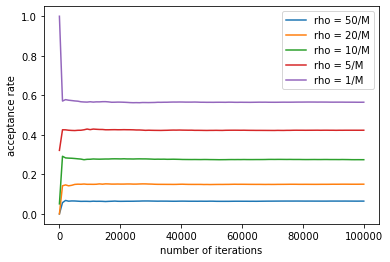

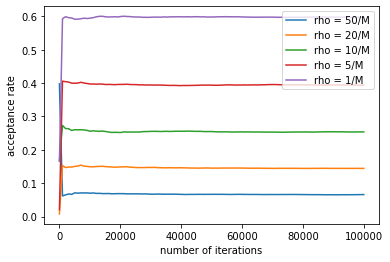

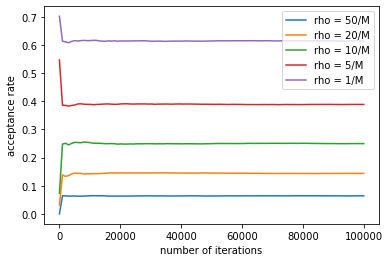

In [179]:
RR = [50,20,10,5,1]
for k in range(len(num_particles)):
    num = 100
    TT = np.linspace(1,T,num)
    avg = np.zeros((num,len(R)))
    for r in range(len(R)):
        for tt in range(len(TT)):
            avg[tt,r] = np.mean(alpha[0:int(TT[tt])+1,r,k])
    plt.figure()
    for r in range(len(R)):
        plt.plot(TT,avg[:,r],label="rho = %i/M"%RR[r])
    plt.legend()
    plt.xlabel('number of iterations')
    plt.ylabel('acceptance rate')
    plt.savefig('acceptance_k_%i.pdf'%k, bbox_inches='tight')

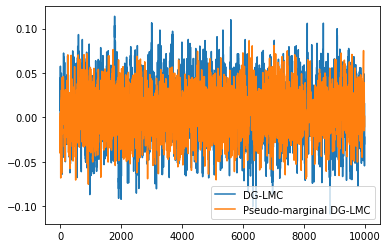

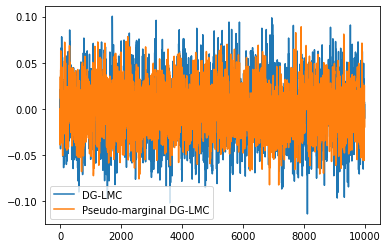

In [142]:
r = 4
k = 2
plt.figure()
plt.plot(theta_dglmc[r,:,0],label="DG-LMC")
plt.plot(theta[r,k,:,0],label="Pseudo-marginal DG-LMC")
plt.legend()

plt.figure()
plt.plot(theta_dglmc[r,:,1],label="DG-LMC")
plt.plot(theta[r,k,:,1],label="Pseudo-marginal DG-LMC")
plt.legend()

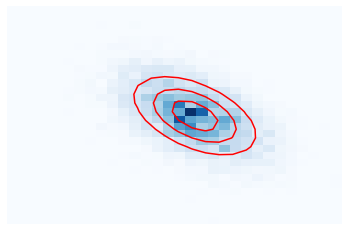

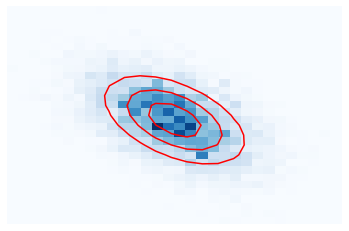

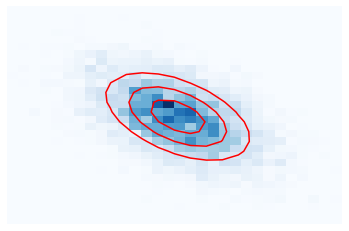

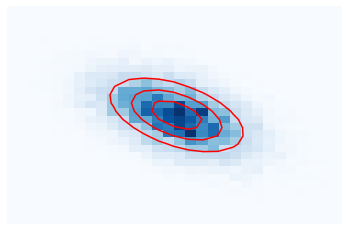

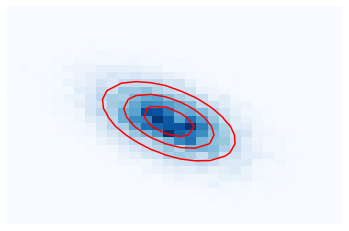

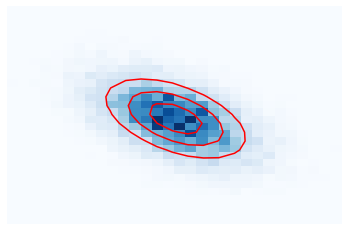

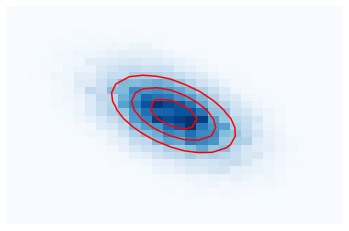

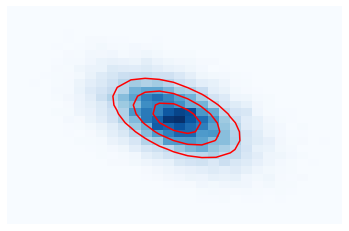

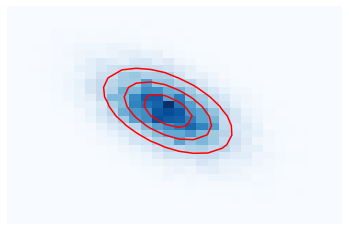

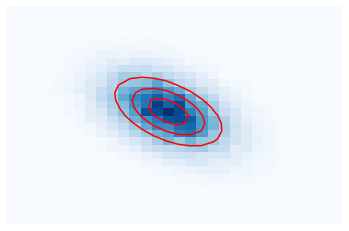

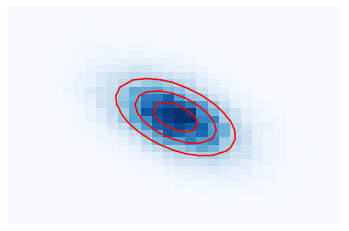

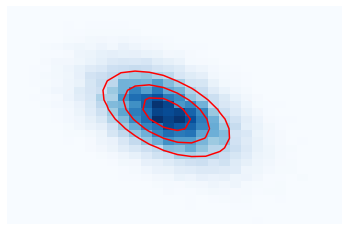

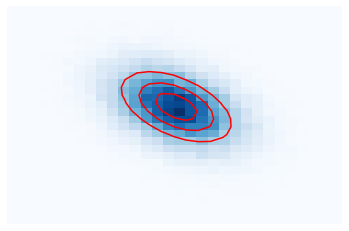

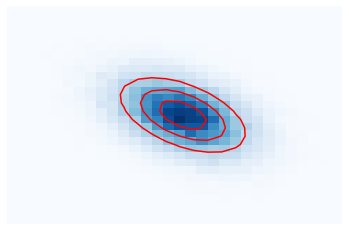

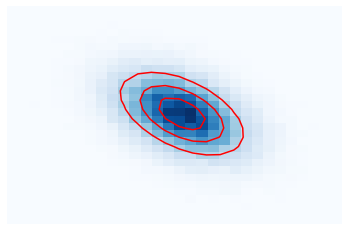

In [155]:
for r in range(len(R)):
    for k in range(len(num_particles)):
        # Plot empirical distribution of pseudo-marginal DG-LMC
        theta_burn = np.squeeze(theta)[r,k,int(T/10):]
        plt.figure()
        #for Xi in Y_split:
        #    gauss_post = GaussianPosterior(Xi, theta_true, sigma0/b, sigma1)
        #    gauss_post.sigma_posterior()
        #    gauss_post.mu_posterior()
        #    sigma_post = gauss_post.sigma_post
        #    mu_post = gauss_post.mu_post
        #    gauss_draw(mu_post, sigma_post, low=-.4, high=.4)
        sigma_post = np.linalg.inv(np.linalg.inv(sigma0) + len(Y)*np.linalg.inv(sigma1))
        gauss_draw_true(sigma_post.dot(np.linalg.inv(sigma1).dot(Y.sum(axis=0)) + np.linalg.inv(sigma0).dot(theta_true)), sigma_post, low=-.4, high=.4)
        plt.hist2d(theta_burn[:,0], theta_burn[:,1],cmap='Blues',bins=30)
        plt.axis('off')
        #plt.autoscale()
        plt.savefig('pseudo_marginal_dglmc_r_%i_k_%i.pdf'%(r,k), bbox_inches='tight')


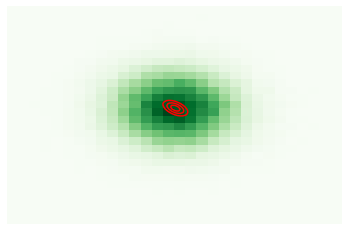

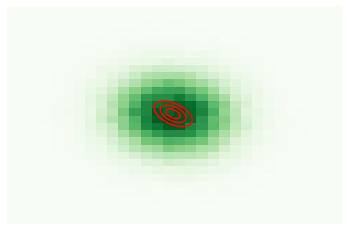

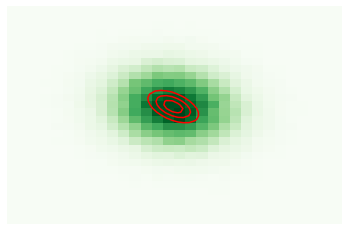

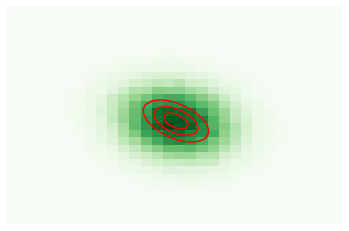

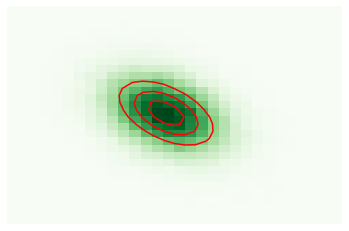

In [168]:
# Plot empirical distribution of DG-LMC
for r in range(len(R)):
    theta_burn = np.squeeze(theta_dglmc)[r,int(T/10):,:]
    plt.figure()
    #for Xi in Y_split:
    #    gauss_post = GaussianPosterior(Xi, theta_true, sigma0/b, sigma1)
    #    gauss_post.sigma_posterior()
    #    gauss_post.mu_posterior()
    #    sigma_post = gauss_post.sigma_post
    #    mu_post = gauss_post.mu_post
    #    gauss_draw(mu_post, sigma_post, low=-.4, high=.4)
    sigma_post = np.linalg.inv(np.linalg.inv(sigma0) + len(Y)*np.linalg.inv(sigma1))
    gauss_draw_true(sigma_post.dot(np.linalg.inv(sigma1).dot(Y.sum(axis=0)) + np.linalg.inv(sigma0).dot(theta_true)), sigma_post, low=-.4, high=.4)
    plt.hist2d(theta_burn[:,0], theta_burn[:,1],cmap='Greens',bins=30)
    plt.axis('off')
    plt.savefig('dglmc_r_%i.pdf'%r, bbox_inches='tight')


In [166]:
theta_dglmc.shape

(5, 10000, 2)

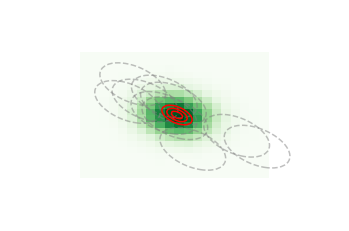

In [255]:
# Plot SGLD
theta_SGLD = theta_SGLD.transpose(0,1,2).reshape(-1,theta_SGLD.shape[2])
plt.figure()
for Xi in Y_split:
    gauss_post = GaussianPosterior(Xi, theta_true, sigma0/b, sigma1)
    gauss_post.sigma_posterior()
    gauss_post.mu_posterior()
    sigma_post = gauss_post.sigma_post
    mu_post = gauss_post.mu_post
    gauss_draw(mu_post, sigma_post, low=-.4, high=.4)
sigma_post = np.linalg.inv(np.linalg.inv(sigma0) + len(Y)*np.linalg.inv(sigma1))
gauss_draw_true(sigma_post.dot(np.linalg.inv(sigma1).dot(Y.sum(axis=0)) + np.linalg.inv(sigma0).dot(theta_true)), sigma_post, low=-.4, high=.4)
plt.hist2d(theta_SGLD[:,0], theta_SGLD[:,1],cmap='Greens',bins=20)
plt.axis('off')
plt.autoscale()